In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import (Input, Conv2D, Dense, MaxPool2D, Dropout,
                          Concatenate, Flatten, GlobalMaxPooling2D, Subtract)
from keras.losses import sparse_categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
import numpy as np
import keras.backend as K
import h5py
from EgoCNN import EgoCNN, EgoDense, EgoInception

Using TensorFlow backend.


In [2]:
class EgoCNN:
    
    def __init__(self, in_size, out_size,
                 batch_size=10,
                 handle=None,
                 xrange=(-3,4), yrange=(-3,4), lscale=7,
                 trange=(-3,4), tbins=20):
        self.in_size = in_size
        self.out_size = out_size
        self.batch_size = batch_size
        self.xrange = xrange
        self.yrange = yrange
        self.lscale = lscale
        self.trange = trange
        self.tbins = tbins
        self.model = self.ego_cnn()
    
    def bcnn(self):
        '''
        Siamese CNN which makes up the bottom part of the network together with its twin.
        '''
        input_tensor = Input(shape=self.in_size)
        x = Conv2D(96, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input_tensor)
        x = MaxPool2D(pool_size=(3,3))(x)
        x = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(x)
        x = MaxPool2D(pool_size=(3,3))(x)
        x = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(x)
        x = MaxPool2D(pool_size=(3,3), name='bcnn_output')(x)
        return Model(input_tensor, x)     
    
    def tcnn(self, bottom_shape=None):
        '''
        Fully connected layers to be plugged on top of the concat siamese CNNs.
        bottom_shape: output shape of one of the bottom CNNs
        y1_shape: number of classes/bins for lateral motion
        y2_shape: number of classes/bins for rotation angles
        '''
        if bottom_shape==None:
            raise Exception('bcnn_shape or output_shape not specified (None)')
        input_streams = Input(shape=bottom_shape)
        x = GlobalMaxPooling2D()(input_streams)
        x = Dense(200, activation='relu')(x)
        Y = Dropout(rate=.5)(x)
        return Model(input_streams, Y)
        
    def ego_cnn(self):
        '''
        Keras model putting together bottom and top NN
        in_size: input image shape, must be coherent with bcnn's input size
        out_size: tuple with number of classes/bins for translations and rotations
        '''
        in_stream1 = Input(shape=self.in_size, name='input0')
        in_stream2 = Input(shape=self.in_size, name='input1')
        bottom = self.bcnn()# self.in_size
        #middle = Concatenate()([bottom(in_stream1), bottom(in_stream2)])
        #middle_size = tuple(a*b for a,b in zip(bottom.output_shape[1:],[1,1,2]))
        middle = Subtract()([bottom(in_stream1), bottom(in_stream2)])
        middle_size = bottom.output_shape[1:]
        top = self.tcnn(middle_size)
        output = top(middle)
        output = [Dense(size, activation='softmax', name=f'output{num}')(output)
                  for num, size 
                  in enumerate(self.out_size)]
        return Model([in_stream1, in_stream2], output)
    
    def batch_generator(self, handle):
        """
        Extract a random batch of images, apply transformations and return both, 
        together with the corresponding transformation parameters

        batch_size: batch size
        handle: hdf5 dataset
        xrange: (min, max+1) range of x translations (ints)
        yrange: (min, max+1) range of y translations (ints)
        trange: (min, max) range of z rotations
        tbins: number of bins in which categorize the z rotations
        """
        # extract batch_size random indices from the dataset for SGD
        total_size = handle.shape[0]
        while True:
            indices = np.random.permutation(range(total_size))[0:self.batch_size]
            indices = np.sort(indices)
            # define batch_size x and y translations as integers in xrange and yrange
            x_trans = np.random.randint(*self.xrange, size=self.batch_size)
            y_trans = np.random.randint(*self.yrange, size=self.batch_size)
            # define batch_size rotations in trange
            z_rotat = np.random.uniform(*self.trange, size=self.batch_size)
            # group them in tbins
            z_rotat = np.digitize(z_rotat, np.linspace(*self.trange, self.tbins+1, endpoint=True))
            # group each x, y , z transformation in a list of batch_size dictionaries
            trans_list = [{'theta': t,'lx': x*self.lscale,'ly': y*self.lscale} 
                            for t, x, y 
                            in zip(z_rotat, x_trans, y_trans)]
            # apply transformations to a batch (hdf5 dataset accepts lists not np.arrays)
            datagen = ImageDataGenerator()
            Xbatch_trans = np.array([datagen.apply_transform(img,tran) 
                                     for img, tran 
                                     in zip(handle[list(indices)],trans_list)])
            Xbatch = handle[list(indices)]
            # turning classes into categorical values
            #classes need to be positive
            Ybatch_tx = to_categorical(x_trans/self.lscale-self.xrange[0], sum(np.absolute(self.xrange))) 
            #classes need to be positive
            Ybatch_ty = to_categorical(y_trans/self.lscale-self.yrange[0], sum(np.absolute(self.yrange))) 
            Ybatch_rot = to_categorical(z_rotat-1, self.tbins) #classes need to start from 0
            #yield (Xbatch, Xbatch_trans), (Ybatch_trans, Ybatch_rot)
            yield ({'input0': Xbatch, 'input1': Xbatch_trans},
                   {'output0': Ybatch_rot, 'output1': Ybatch_tx, 'output2': Ybatch_ty})


class EgoDense(EgoCNN):
    def bcnn(self):
        model = DenseNet169(include_top=False,
                            weights='imagenet',
                            input_shape=self.in_size,
                            pooling=None)
        return model

    
class EgoInception(EgoCNN):
    def bcnn(self):
        model = InceptionV3(include_top=False,
                            weights='imagenet',
                            input_shape=self.in_size,
                            pooling=None)
        return model

In [3]:
f = h5py.File('extraimages_224.hdf5') 
ego_cnn = EgoCNN(in_size=(224,224,3), out_size=(20,7,7), handle=f['train_img'])
model = ego_cnn.model
model.compile(optimizer='adam',
              loss={'output0': 'categorical_crossentropy',
                    'output1': 'categorical_crossentropy',
                    'output2': 'categorical_crossentropy'},
              metrics=['acc'])
#train_generator = ego_cnn.batch_generator()
#model.fit_generator(train_generator,
#                    steps_per_epoch=1,
#                    epochs=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


3


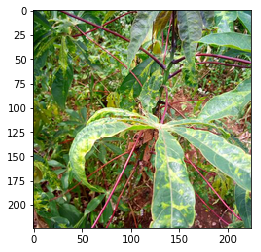

In [11]:
for item in ego_cnn.batch_generator(f['train_img']):
    print(np.random.randint(4))
    plt.imshow(item[0]['input0'][0])
    break